# Supervised Learning - Project

In this Project, we are going to perform a full unsupervised learning machine learning project on a "Wholesale Data" dataset. The dataset refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories

[Kaggle Link](https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set)

# Part I : EDA - Exploratory Data Analysis & Pre-processing

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans


df = pd.read_csv('Wholesale_Data.csv')

In [2]:
df.head(4)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788


In [3]:
df.describe(include = 'all')

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
print(df.isnull().sum())    
## no nulls


Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [4]:
print(  df.duplicated().sum())
# no duplicates


0


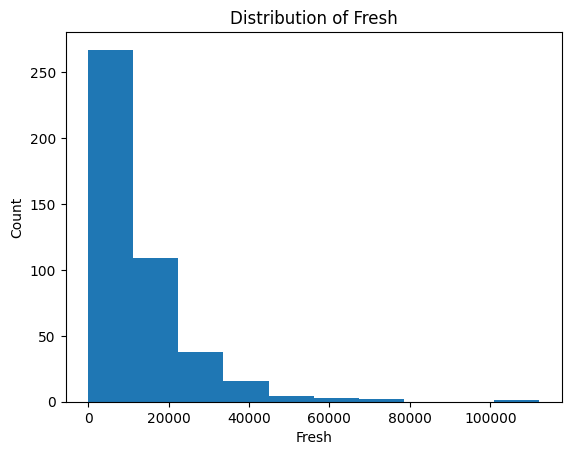

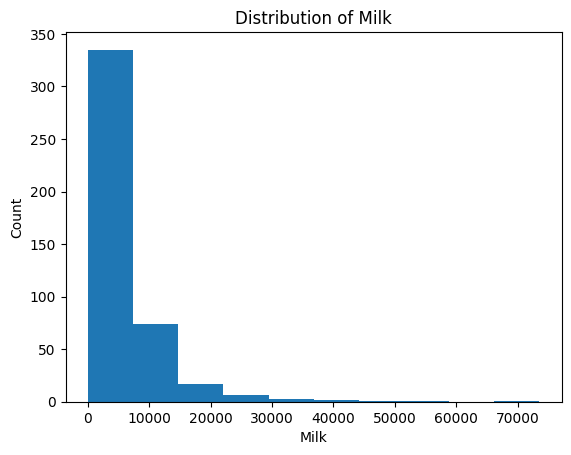

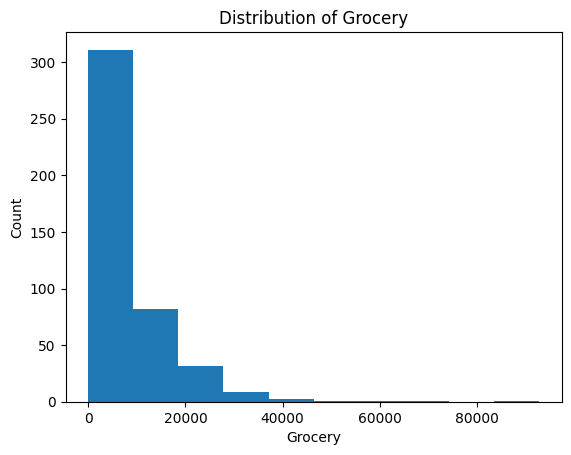

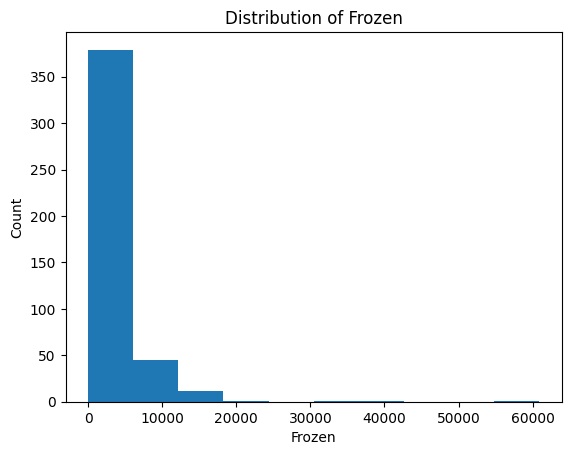

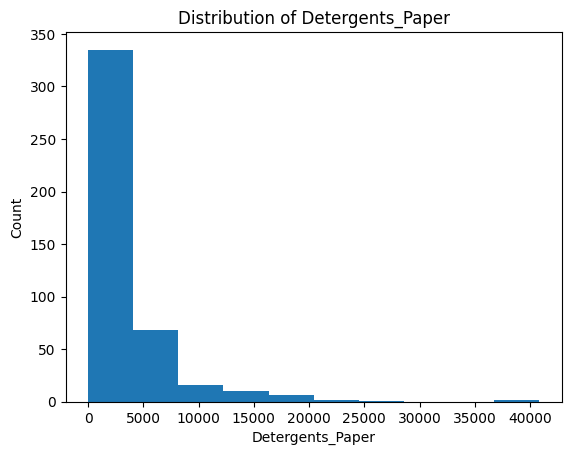

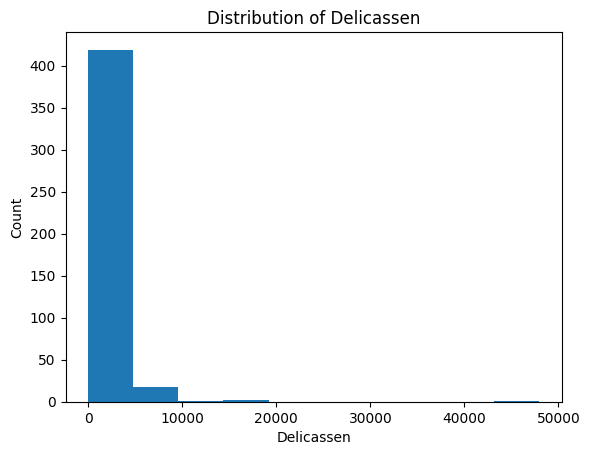

In [22]:
for column in df.columns[2:]:
    plt.figure() 
    df[column].plot(kind='hist', title=f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

    ## distribution check

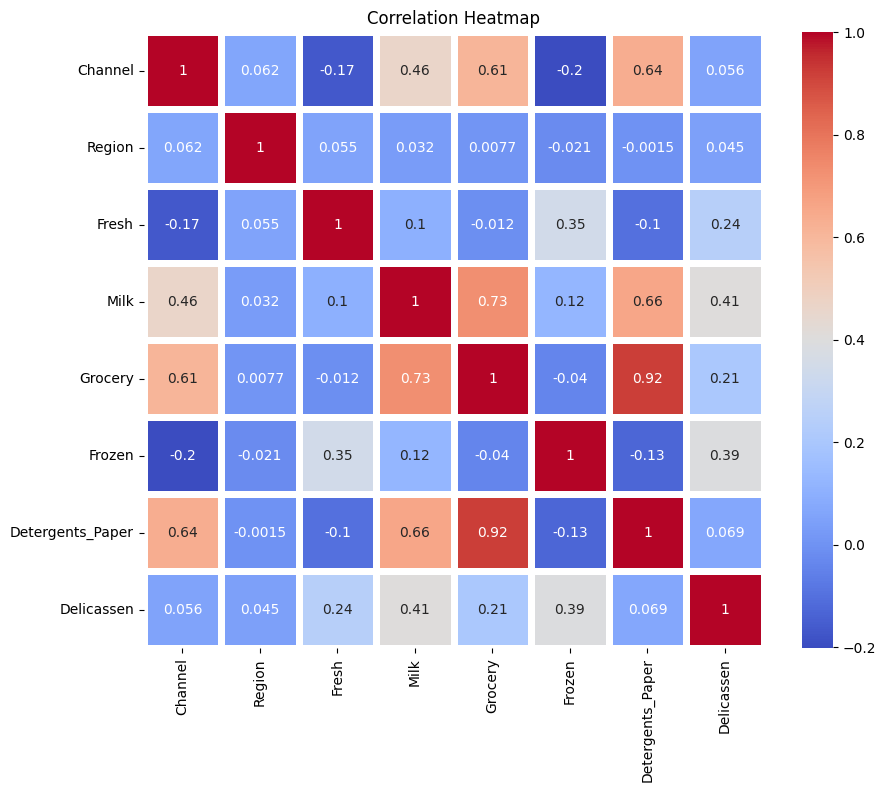

In [15]:
correlation_matrix=df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap = 'coolwarm', linewidths=5)
plt.title("Correlation Heatmap")
plt.show()

## There seems to be a correlation between detergents_paper, milk, and groceries.  Those are probably big grocery stores.

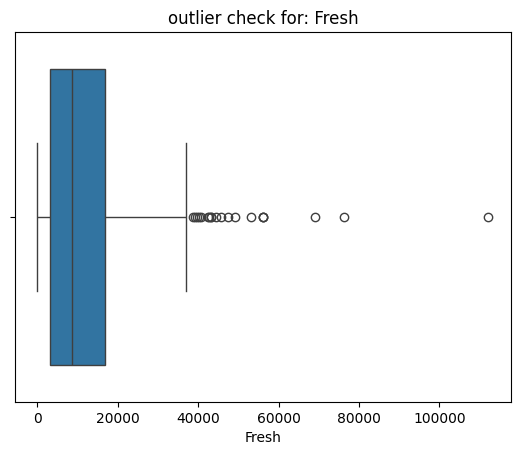

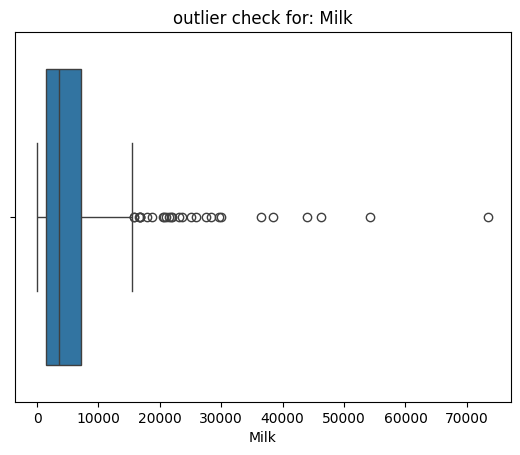

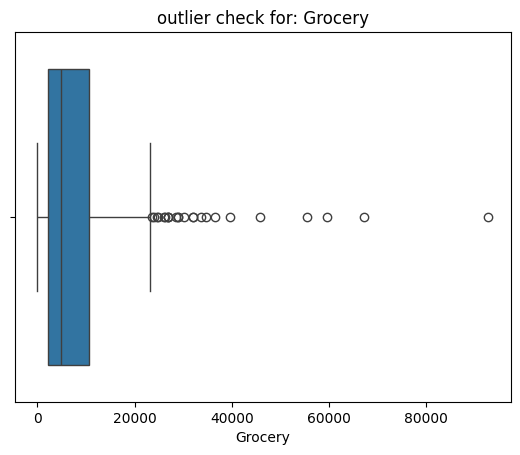

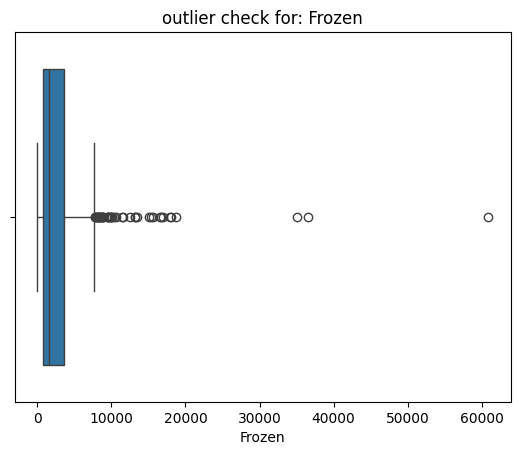

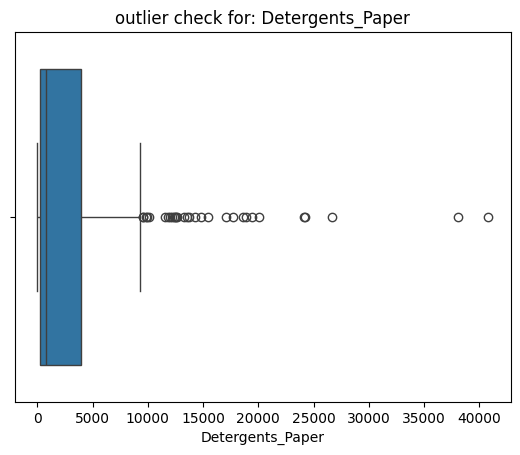

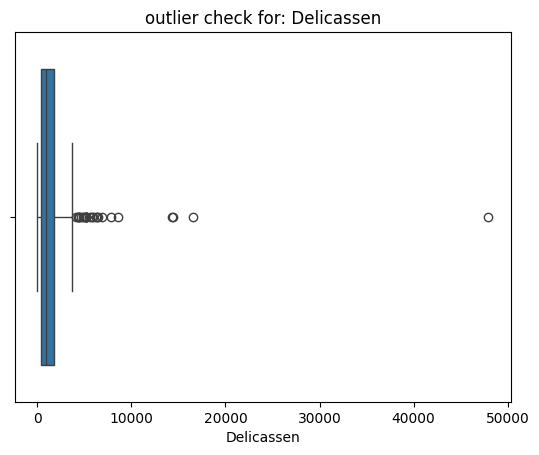

In [23]:
for column in df.columns[2:]:
    plt.figure()
    plt.title('outlier check for: ' + column)
    sns.boxplot(x = column, data = df)


In [3]:
def remove_outliers(df):  ## this will replace outliers with null
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3-Q1  ## gets quartiles and IQR
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)  ## setting the limits of allowable datapoints, 1.5*IQR is standard
    filter = (df >= lower_bound) & (df <= upper_bound)
    return df[filter]

cleandf = df.apply(remove_outliers, axis=0)  ## Creates our new cleandf by applying the function to all columns except Outcome


In [4]:
cleandf.dropna(inplace=True)
## drop the nulls we just made
cleandf.shape
## We now have 332 rows out of the initial 440

(332, 8)

Channel and Regional seem to be nominal categorical variables so we have to change them to numerical with one-hot encoding

In [5]:
cleandf = pd.get_dummies(cleandf, columns=[ 'Channel' , 'Region'], dtype=int)


In [49]:
cleandf.head(1)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,0,1,0,0,1


The other columns are all in monetary units so scaling shouldnt be necessary

# Part II - KMeans Clustering

In [ ]:
## Using the elbow method to determine the optimal number of clusters
sse = []
for k in range(1,11):
    km = KMeans(n_clusters=k)
    km.fit(cleandf)
    sse.append(km.inertia_)

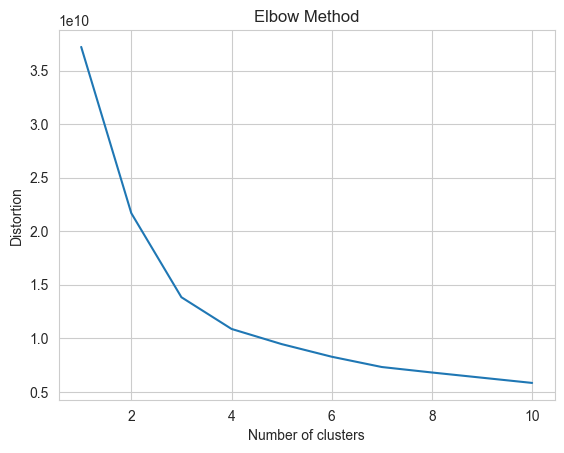

In [75]:


g=sns.lineplot(x=range(1,11), y=sse)
 
g.set(xlabel ="Number of clusters", 
      ylabel = "Distortion", 
      title ='Elbow Method')
 
plt.show()

## It seems like 3 is the optimal amount of clusters

In [ ]:
km=KMeans(n_clusters=3)
km.fit(cleandf)

## refitting the model with our optimal number of clusters



In [ ]:
cleandf['K_Cluster'] = km.fit_predict(cleandf)
## creates a new column with the cluster each customer is assigned to


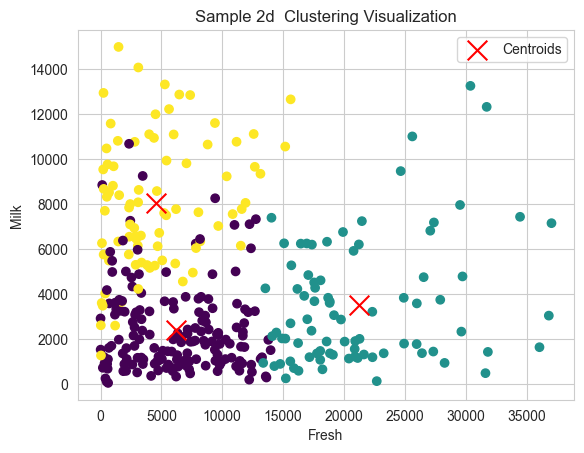

In [91]:
centroids = km.cluster_centers_

plt.scatter(cleandf['Fresh'], cleandf['Milk'], c=cleandf['K_Cluster'], cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, c='red', label='Centroids')
plt.title('Sample 2d  Clustering Visualization')
plt.xlabel('Fresh')
plt.ylabel('Milk')
plt.legend()
plt.show()

## Sample 2d visualization of the clusters using the first 2 columns

# Part III - Hierarchical Clustering 

In [114]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster  import AgglomerativeClustering
import scipy.cluster._hierarchy as sch


cleandf2 = cleandf.drop(columns = ['K_Cluster'])  ## new temporary df without the K_cluster column from last step

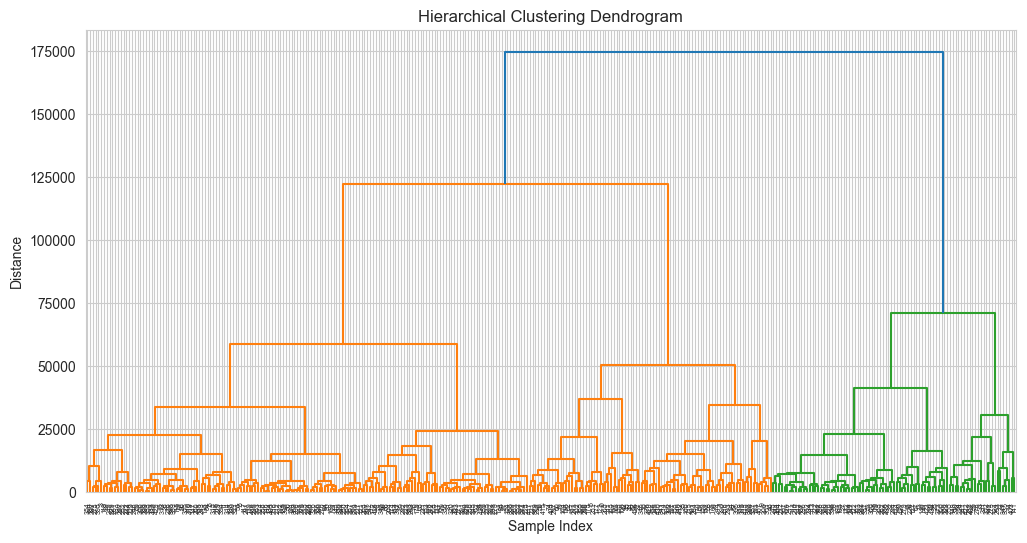

In [124]:
linkage_matrix = linkage(cleandf2, method='ward')  ## used to make the dendrogram


plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=cleandf2.index, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

## There is a pretty clear long vertical section we can  slice  to cut into 3 seperate clusters again

In [ ]:
ac  = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  ## our heirarchical model

cleandf['H_Cluster'] = ac.fit_predict(cleandf) ## adds another column to the df with the heirarchical assigned cluster



In [130]:
cleandf.head(4)
## the DF now has both clusters

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3,K_Cluster,H_Cluster
0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,0,1,0,0,1,2,2
1,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,0,1,0,0,1,2,2
3,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,1,0,0,0,1,0,1
5,9413.0,8259.0,5126.0,666.0,1795.0,1451.0,0,1,0,0,1,0,2


# Part IV - PCA

In [131]:
from sklearn.decomposition import PCA

pca = PCA (n_components = None)

dfx = pca.fit(cleandf2)  ## using the df without the 2 cluster columns

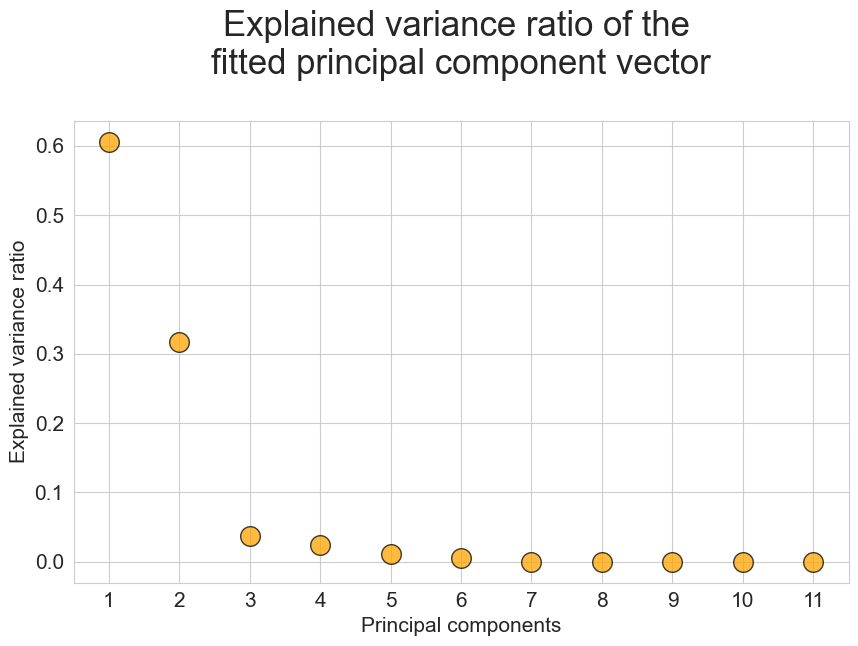

In [132]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(dfx.explained_variance_ratio_))],
            y=dfx.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(dfx.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [133]:
pca.explained_variance_ratio_

## the first 2 explain 60% and 30% of the variance, and the rest 3% or less 
## 2 seems to be the optimal number

array([6.06153017e-01, 3.16583598e-01, 3.74574331e-02, 2.41376522e-02,
       1.06413159e-02, 5.02697901e-03, 2.80354640e-09, 1.33978995e-09,
       1.03427917e-09, 7.91113146e-41, 5.56513021e-42])

In [141]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cleandf2)
columns_pc = ['PrincipalComponent1', 'PrincipalComponent2']
df_pc = pd.DataFrame(principal_components, columns=columns_pc, index=cleandf2.index)

## Refitting our pca with the optimal number of components and creating a dataframe from it


In [144]:
df_final = pd.concat([cleandf, df_pc], axis=1)

## We now have a dataframe with The assigned K-means cluster and Heirarchical clusters, as well as the principal compenents from PCA.

In [145]:
df_final


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3,K_Cluster,H_Cluster,PrincipalComponent1,PrincipalComponent2
0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,0,1,0,0,1,2,2,2193.462435,4864.859650
1,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,0,1,0,0,1,2,2,-3610.093574,5552.398395
3,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,1,0,0,0,1,0,1,4493.988160,-2558.179011
5,9413.0,8259.0,5126.0,666.0,1795.0,1451.0,0,1,0,0,1,0,2,-381.974062,1318.786386
6,12126.0,3199.0,6975.0,480.0,3140.0,545.0,0,1,0,0,1,0,1,2233.731660,1402.922949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,21117.0,1162.0,4754.0,269.0,1328.0,395.0,1,0,0,0,1,1,0,11712.272695,-77.798551
433,1982.0,3218.0,1493.0,1541.0,356.0,1449.0,1,0,0,0,1,0,1,-6480.856205,-5917.508582
434,16731.0,3922.0,7994.0,688.0,2371.0,838.0,1,0,0,0,1,1,0,6607.683765,3235.794240
438,10290.0,1981.0,2232.0,1038.0,168.0,2125.0,1,0,0,0,1,0,1,1631.760733,-4226.736111


# Part V - Conclusion

- Customers who buy alot of "detergent_paper" also tend to buy more milk and groceries
- If we wanted to simplify our data and models, we can capture 90% of the variance with just 2 principal components
- Both K_Means and Heirarchical Clustering Identified 3 main clusters of customers
- Customers spend the most on Fresh food